##Notebook 3: Evaluación y comparación de resultados ##

El objetivo es la evaluación y comparación de los resultados del modelo.

El notebook que desarrollaremos se centra en la evaluación del modelo entrenado y las métricas de desempeño (precisión, accuracy, recall, F1-Score, entre otros).

Que contiene:
1) Cálculo de métricas como precisión, recall, F1-score.
2) Matriz de Confusión.
3) Reporte de clasificación.




1. Instalamos e importamos las librerías.

In [ ]:
!pip -q install -U transformers accelerate datasets deep-translator

import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.3 MB/s eta 0:00:00


2. Montamos el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


3. Cargamos el CSV limpio + el split reproducible.

In [ ]:
csv_path = "/content/drive/MyDrive/proyecto_ia/amazon_reviews_limpio.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print(df["label"].value_counts())
df.head()


Shape: (21255, 2)
label
2    18806
0     2144
1      305
Name: count, dtype: int64


,reviewText,label
0,i have bought several of the vitality canned d...,2
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,2
3,if you are looking for the secret ingredient i...,2
4,great taffy at a great price there was a wide ...,2


In [ ]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (17004, 2) Test: (4251, 2)


4. Cargamos el modelo guardado

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/proyecto_ia/modelos/sentimiento_xlmroberta_v1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Modelo cargado ✅ en:", MODEL_DIR)
print("Device:", device)


The tokenizer you are loading from '/content/drive/MyDrive/proyecto_ia/modelos/sentimiento_xlmroberta_v1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Modelo cargado ✅ en: /content/drive/MyDrive/proyecto_ia/modelos/sentimiento_xlmroberta_v1
Device: cuda


5. Predicciones en el set de prueba.

In [ ]:
def predecir_batch(textos, batch_size=32, max_length=128):
    model.eval()
    preds = []

    for i in range(0, len(textos), batch_size):
        batch = textos[i:i+batch_size]
        inputs = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(-1).cpu().numpy()

        preds.extend(batch_preds)

    return np.array(preds)

y_true = test_df["label"].values
textos_test = test_df["reviewText"].astype(str).tolist()

y_pred = predecir_batch(textos_test)

print("✅ Predicciones generadas:", len(y_pred))


✅ Predicciones generadas: 4251


6. Reporte de clasificación

In [ ]:
target_names = ["negativo", "neutro", "positivo"]

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", round(acc, 4))


=== Classification Report ===
              precision    recall  f1-score   support

    negativo     0.8438    0.0629    0.1171       429
      neutro     0.0000    0.0000    0.0000        61
    positivo     0.8912    0.9997    0.9424      3761

    accuracy                         0.8908      4251
   macro avg     0.5783    0.3542    0.3532      4251
weighted avg     0.8736    0.8908    0.8456      4251

Accuracy: 0.8908


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7. Matriz de confusión + Heatmap

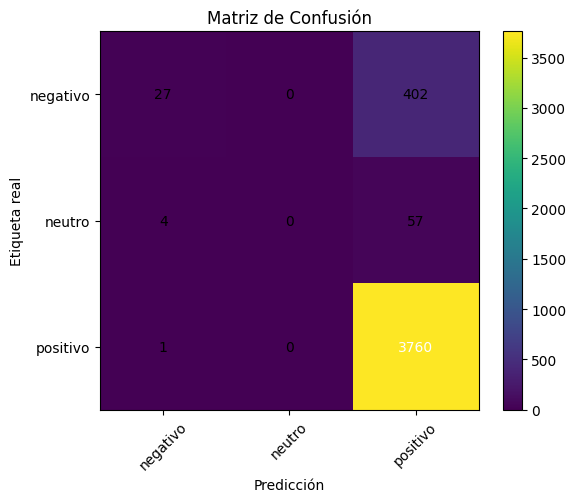

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusión")
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Escribir los valores en cada celda
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


8. Análisis de errores
8.1 Vemos ejemplos mal clasificados.

In [ ]:
errores = test_df.copy()
errores["pred"] = y_pred
errores["correcto"] = errores["label"] == errores["pred"]

malos = errores[errores["correcto"] == False].copy()
print("Total errores:", len(malos))

malos.sample(10, random_state=42)[["reviewText", "label", "pred"]]


Total errores: 464


,reviewText,label,pred
7099,i fill up a dozen of these with dd dark and ta...,0,2
11584,i hope this may help others whose dogs love th...,0,2
2238,received different than pictured labels just s...,0,2
4571,the initial aroma upon opening the package was...,0,2
14415,outstanding this difficult to find product is ...,0,2
4086,the level from this unit was hard to adjust an...,0,2
11615,having multuple dogs to feed snacks to i can t...,0,2
15964,if you like black tea this is it no flavors ad...,0,2
8254,i used to order this product at per box of can...,1,2
7343,i have only eaten the raw and they were as exp...,0,2


8.2 Vemos en que clase falla más.

In [ ]:
conteo_fallos = malos.groupby(["label", "pred"]).size().reset_index(name="cantidad")
conteo_fallos.sort_values("cantidad", ascending=False)


,label,pred,cantidad
0,0,2,402
2,1,2,57
1,1,0,4
3,2,0,1


9. Conclusiones:

*   El modelo presenta un desempeño global satisfactorio, reflejado en métricas como Accuracy y F1-score ponderado.

*   La matriz de confusión muestra que la mayoría de predicciones se concentran correctamente en las clases positivo y negativo, mientras que la clase neutro tiende a ser menos frecuente y más difícil de identificar.

*   El análisis de errores evidencia que varias reseñas “intermedias” (opiniones sin emoción fuerte) pueden ser interpretadas como positivas o negativas, lo cual es consistente con la distribución del dataset y con la dificultad natural del sentimiento neutro.

*   En pruebas en español, se observó degradación inicial debido a que el dataset de entrenamiento está principalmente en inglés. Para mitigar esto, se implementó una etapa de traducción automática (ES→EN) antes de la inferencia, mejorando la coherencia de las predicciones en español.

*   Como mejora futura, se recomienda entrenar/fine-tunear con un dataset en español o realizar un entrenamiento multilingüe balanceado para aumentar la sensibilidad hacia la clase neutra y reducir errores en textos ambiguos.

10. Guardar reporte en Drive

In [ ]:
reporte_path = "/content/drive/MyDrive/proyecto_ia/resultados/reporte_classification.txt"
os.makedirs(os.path.dirname(reporte_path), exist_ok=True)

rep = classification_report(y_true, y_pred, target_names=target_names, digits=4)

with open(reporte_path, "w", encoding="utf-8") as f:
    f.write(rep)

print("✅ Reporte guardado en:", reporte_path)


✅ Reporte guardado en: /content/drive/MyDrive/proyecto_ia/resultados/reporte_classification.txt


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
